In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import normaltest

# в модуле statsmodels реализованы методы статистического моделирования для временных рядов

import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv('/opt/kate_repo/real_data_analysis/wargaming_task/Wargaming_task_one.csv')
df.head()

,dt,"Revenue, BYN"
0,02/02/2017,7402991
1,02/03/2017,7165318
2,02/04/2017,7034603
3,02/05/2017,8901133
4,02/06/2017,9238895


In [4]:
df.dtypes

dt              object
Revenue, BYN     int64
dtype: object

In [5]:
# Корректировка формата даты
df['dt'] = pd.to_datetime(df['dt'])

In [6]:
# Переименование столбцов
df.rename(columns=lambda x: x.replace('dt', 'date'), inplace=True)
df.rename(columns=lambda x: x.replace('Revenue, BYN', 'revenue'), inplace=True)

In [7]:
# Добавление данных о днях недели
df['day_of_week'] = df['date'].apply(lambda time: time.strftime("%A"))

In [8]:
df

,date,revenue,day_of_week
0,2017-02-02,7402991,Thursday
1,2017-02-03,7165318,Friday
2,2017-02-04,7034603,Saturday
3,2017-02-05,8901133,Sunday
4,2017-02-06,9238895,Monday
...,...,...,...
265,2017-10-25,6257772,Wednesday
266,2017-10-26,6827791,Thursday
267,2017-10-27,7789467,Friday
268,2017-10-28,6911239,Saturday


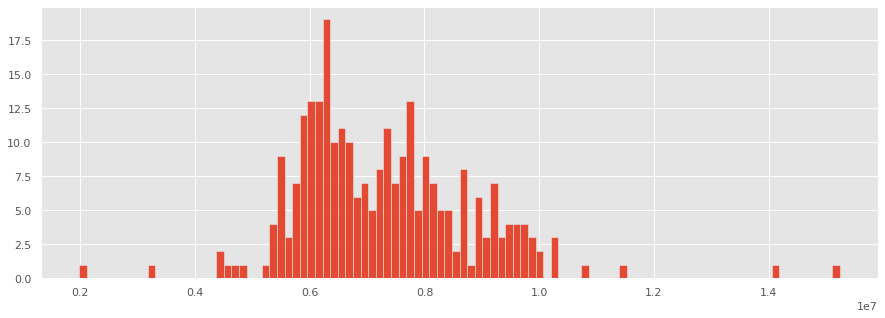

In [9]:
df.revenue.hist(bins=100);

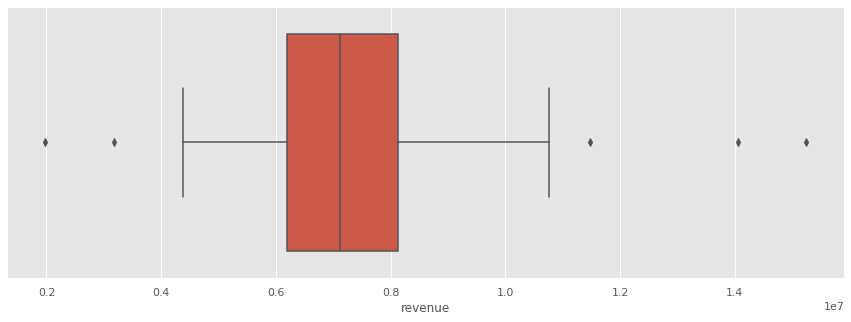

In [10]:
# Распределение параметра revenue

sns.boxplot(df['revenue'], orient='h');

In [11]:
df.revenue.describe()

count    2.700000e+02
mean     7.281373e+06
std      1.530439e+06
min      1.978644e+06
25%      6.200241e+06
50%      7.112128e+06
75%      8.135015e+06
max      1.524611e+07
Name: revenue, dtype: float64

In [12]:
# Коэффициент вариации (степень изменчивости по отношению к среднему показателю выборки)
print('V = %f' % (df.revenue.std()/df.revenue.mean()))

V = 0.210186


In [13]:
# Оценка распределения дохода
data = df.revenue

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нормальное распределение дохода')
else:
    print('Распределение дохода не является нормальным')

Statistics=56.931, p=0.000
Распределение дохода не является нормальным


In [14]:
# Динамика дохода за весь период

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace1 = go.Scatter(x = df.date,
                    y = df.revenue,
                    name = "Динамика дохода",
                    line = dict(color = 'blue'),
                    opacity = 0.4)

layout = dict(title='Динамика дохода',)

fig = dict(data=[trace1], layout=layout)
iplot(fig)

Визуально временной ряд выглядит как стационарный - отсутствует четкая тенденция и сезонный эффект
Так как распределение не соответствует нормальному, исследование временного ряда по средним величинам не будет достоверным, поэтому для статистического определения насколько сильно временной ряд определеяется трендом будет использован Augmented Dickey–Fuller test, 
где нулевая гипотеза - временной ряд является нестационарным и имеет временную структуру.

In [15]:
# насколько сильно временной ряд определяется трендом
from statsmodels.tsa.stattools import adfuller

X = df.revenue.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.462995
p-value: 0.000229
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


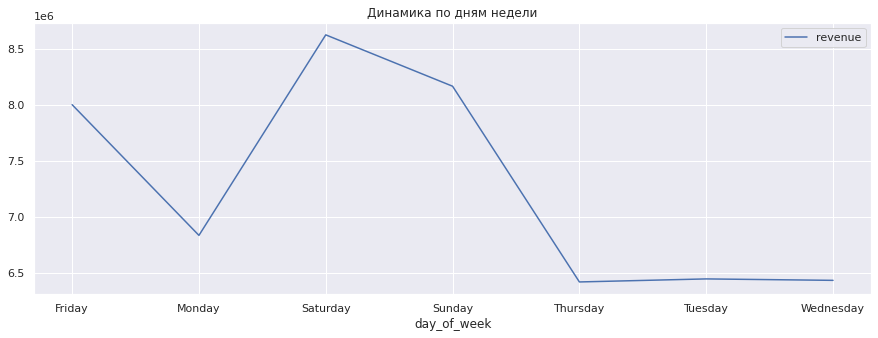

In [16]:
# График изменения дохода по дням недели
sns.set() # стили библиотеки Seaborn
df.pivot_table('revenue', index='day_of_week',aggfunc='mean').plot()
plt.title('Динамика по дням недели'); 
# изменить расположение дней недели (не по алфавиту)

In [17]:
df.date.max()

Timestamp('2017-10-29 00:00:00')

In [18]:
# Фильтр по периоду скидки с 13.10.17 по 16.10.17
sale_date=df[(df['date'] >= '2017-10-13') & (df['date'] <= '2017-10-16')]

In [19]:
# Фильтр с 27.09.17 по 16.10.17
renewal_date=df[(df['date'] >= '2017-09-27') & (df['date'] <= '2017-10-16')]

In [20]:
# Фильтр до 13.10.2017
before_sale=df[(df['date'] < '2017-10-13')]

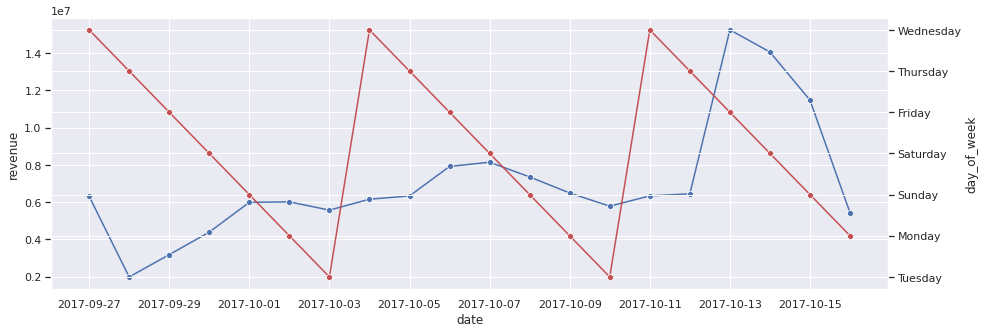

In [21]:
# Динамика дохода после обновления
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(x=renewal_date.date,
            y=renewal_date.revenue, 
            color='b',marker='o',
            ax=ax1)

# Дни недели
sns.lineplot(x=renewal_date.date, 
             y=renewal_date.day_of_week,
             color='r',marker='o',
             ax=ax2);
# Можно сделать гистограмму для дней недели и закрашивать только субботу и воскресенье

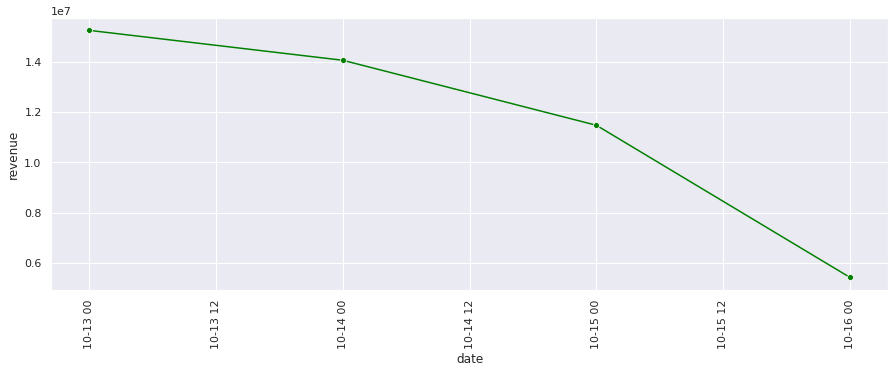

In [22]:
# Динамика дохода во время действия скидки
x = sale_date.date
y = sale_date['revenue']
sns.lineplot(x=x, y=y, data=sale_date, marker='o', color='green')

plt.xticks(rotation=90);

In [23]:
# первый день скидки
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(before_sale.revenue, 24)

6459241.208333333

In [24]:
# второй день скидки
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(before_sale.revenue, 48)

6906877.979166667

In [25]:
# третий день скидки
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(before_sale.revenue, 72)

6804728.263888889